In [64]:
import importlib
import pandas as pd
import random
import re
import zss
import sexpdata
import coq_serapy
from numpy import NaN
from numpy import mean
from collections import Counter
import utils
import log_parser
import generate_dataframes
importlib.reload(utils)
importlib.reload(log_parser)
importlib.reload(generate_dataframes)


<module 'generate_dataframes' from '/home/yousef/lemmaranker/generate_dataframes.py'>

In [5]:
def sexp_size(sexp):
  if isinstance(sexp, list):
    return sum(sexp_size(child) for child in sexp)
  else:
    return 1

def sexp_to_tree(sexp):
  if isinstance(sexp, list):
    tree = zss.Node(sexp[0])
    for i in range(1, len(sexp)):
      tree.addkid(sexp_to_tree(sexp[i]))
    return tree
  else:
    return zss.Node(sexp)

def ted_distance(s1, s2):
  return zss.distance(sexp_to_tree(sexpdata.loads(s1)), sexp_to_tree(sexpdata.loads(s2)), zss.Node.get_children, insert_cost, remove_cost, update_cost1)
  return zss.simple_distance(sexp_to_tree(s1), sexp_to_tree(s2), zss.Node.get_children, zss.Node.get_label, my_label_distance)

def insert_cost(n):
  return depth(n)

def remove_cost(n):
  return depth(n)

def update_cost1(n1, n2):
  return my_label_distance(zss.Node.get_label(n1), zss.Node.get_label(n2)) + abs(depth(n1) - depth(n2))

def update_cost2(n1, n2):
  children1 = zss.Node.get_children(n1)
  children2 = zss.Node.get_children(n2)
  if not children1:
    return depth(n2)
  if not children2:
    return depth(n1)
  dist = my_label_distance(zss.Node.get_label(n1), zss.Node.get_label(n2))
  if len(children1) > len(children2):
    small = children2
    big = children1
  else:
    small = children1
    big = children2
  for i in range(len(small)):
    dist += update_cost2(big[i], small[i])
  for i in range(len(small), len(big)):
    dist += insert_cost(big[i])
  return dist


def my_label_distance(l1, l2):
  if l1 == l2:
    return 0
  else:
    return 1

def depth(tree : zss.Node):
  if not zss.Node.get_children(tree):
    return 1
  else:
    return 1 + max(depth(child) for child in zss.Node.get_children(tree))

In [6]:
def ted(t1, t2):
  return ted_distance(t1, t2)

def sed(s1, s2):
  import editdistance
  return editdistance.eval(s1, s2)

def get_thereorem_body(s):
  if match := re.match(f'(Lemma|Theorem) (\w+)[ ]?:(?P<body>.+)', s):
    return match.groupdict()["body"].strip()
  else:
    return s

def get_goal(s):
  if match := re.match(f'(.*)(forall|exists) (.+),(?P<goal>[\w\W]+)', s):
    return match.groupdict()["goal"].strip()
  else:
    return s

In [7]:
df = pd.read_pickle('./clam.pickle')

frames = []
for filename in df["file"].unique():
  frame = df[df["file"] == filename]
  if 1 in frame['cat'].unique():
    continue
  elif frame['is_equiv'].any():
    frames.append(frame)
  else:
    print(f"Excluding file: {filename} because none of the synthesized lemmas are equivalent to human lemma")
frames = sorted(frames, key=lambda frame: frame.file[0])
for frame in frames:
  print(frame.at[0, 'file'])

Excluding file: clam_lf_goal8_drop_Cons_assoc_34_drop_Cons because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal33_mult_succ_81_plus_commut because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal8_drop_Cons_assoc_33_drop_Cons because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal4_theorem0_39_lem because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal38_theorem0_56_goal37 because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal45_theorem0_63_Nat_beq_refl because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal33_mult_succ_81_plus_assoc because none of the synthesized lemmas are equivalent to human lemma
Excluding file: clam_lf_goal31_qreva_qreva_67_qreva_nil because none of the synthesized lemmas are equivalent to human lemma
Excluding f

In [8]:
for i in range(len(frames)):
  print(frames[i].is_equiv.any())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
def random_rank(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    for iter in range(100):
      for i, _ in frames[index].iterrows():
        frames[index].loc[i, 'alpha'] = random.uniform(0,1)    
      all_equiv = []
      sorted_frame = frames[index].sort_values('alpha', ascending=False, ignore_index=True)
      for i, row in sorted_frame.iterrows():
        if row['is_equiv']:
          all_equiv.append(i)
      if not all_equiv:
        all_equiv.append(NaN)
      first_rank[index].append(all_equiv[0])
      mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [44]:
def order_by(frames, sort_values, normalize=False):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values(sort_values, ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  denom = [len(frame)/100 if normalize else 1 for frame in frames]
  return [mean(first_rank[i])/denom[i] for i in range(len(frames))], [mean(mean_rank[i])/denom[i] for i in range(len(frames))]

def order_by_alpha(frames):
  return order_by(frames, ['alpha'])

def order_by_lemma_len(frames):
  return order_by(frames, ['lemma_len'])

def order_by_ted(frames):
  return order_by(frames, ['ted'])

def order_by_sed(frames):
  return order_by(frames, ['sed'])

def order_by_lfind(frames):
  return order_by(frames, ['cat', 'lemma_len'])

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from torch import alpha_dropout, norm
def visualize_ranks(label, frames, first_ranks, avg_ranks, normalize=True):
  ordered_frames = sorted(frames, key=lambda frame: frame.file[0])
  denom = [len(frame) if normalize else 1 for frame in ordered_frames]
  data = [
    [first_ranks[i]*100/denom[i] for i in range(len(ordered_frames))],
    [avg_ranks[i]*100/denom[i] for i in range(len(ordered_frames))],
    [len(frame) for frame in ordered_frames]]
  X = np.arange(len(ordered_frames))
  fig = plt.figure(figsize=(len(frames)/4,5))
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(ordered_frames)), [frame.at[0, 'file'][13:] for frame in ordered_frames])
  ax.bar(80 * X + -10, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 10, data[1], color = 'g', width = 20)
  if normalize:
    ax.bar(80 * X, 100, color = 'gray', alpha=0.15, width=40)
  else:
    ax.bar(80 * X + 0, data[2], color = 'gray', alpha=0.15, width = 40)
  ax.legend(['First', 'Mean', 'Total'])
  ax.axhline(y=mean(data[0]), color='b', linestyle='dashed')
  ax.axhline(y=mean(data[1]), color='g', linestyle='dashed')
  if normalize:
    label += '(Normalized)'
  ax.set_title(label)
  fig.autofmt_xdate()
  fig.set_dpi(100)

def visualize_rank_difference(label, frames, first_ranks1, avg_ranks1, first_ranks2, avg_ranks2, normalize=True):
  ordered_frames = sorted(frames, key=lambda frame: frame.file[0])
  denom = [len(frame) if normalize else 1 for frame in ordered_frames]
  data = [
    [(first_ranks1[i] - first_ranks2[i])*100/denom[i] for i in range(len(ordered_frames))],
    [(avg_ranks1[i] - avg_ranks2[i])*100/denom[i] for i in range(len(ordered_frames))],
    [len(frame) for frame in ordered_frames]
  ]
  X = np.arange(len(ordered_frames))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(ordered_frames)), [frame.at[0, 'file'][13:] for frame in ordered_frames])

  ax.bar(80 * X + -10, data[0], color = 'b', width = 20)
  ax.bar(80 * X + 10, data[1], color = 'g', width = 20)
  ax.legend(['First', 'Mean', 'Total'])
  if normalize:
    label += '(Normalized)'
  ax.set_title(label)
  yabs_max = abs(max(ax.get_ylim(), key=abs))
  ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
  fig.autofmt_xdate()
  fig.set_dpi(100)



/home/yousef/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


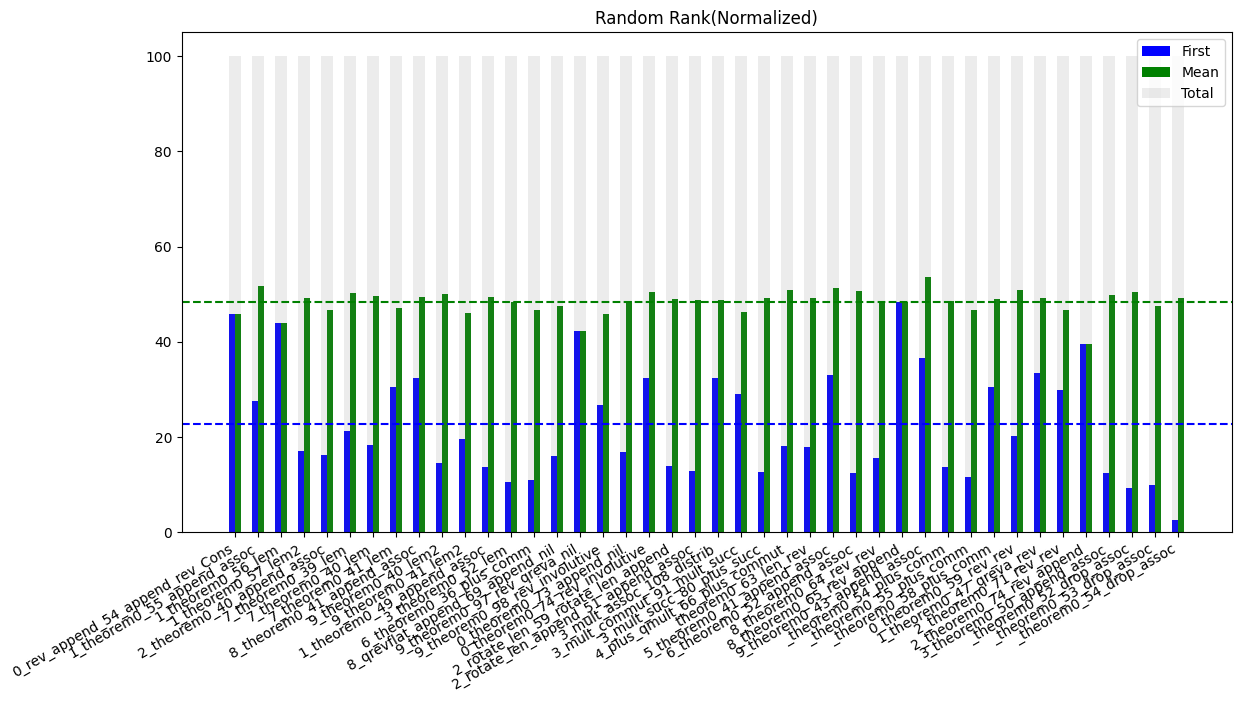

In [24]:
rand_first_ranks, rand_avg_ranks = random_rank(frames)
visualize_ranks("Random Rank", frames, rand_first_ranks, rand_avg_ranks)

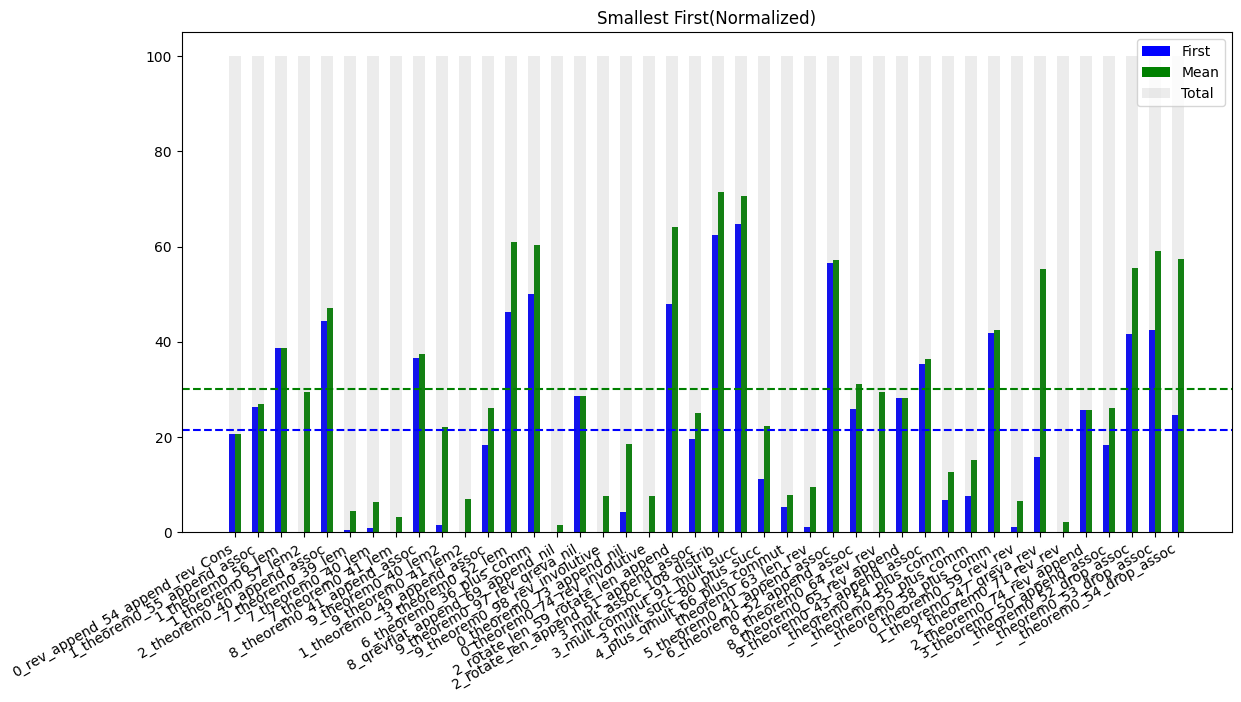

In [11]:
small_first_ranks, small_avg_ranks = order_by_lemma_len(frames)
visualize_ranks("Smallest First", frames, small_first_ranks, small_avg_ranks)

In [12]:
visualize_rank_difference("Rand vs. Smallest", frames, rand_first_ranks, rand_avg_ranks, small_first_ranks, small_avg_ranks, normalize=True)

NameError: name 'rand_first_ranks' is not defined

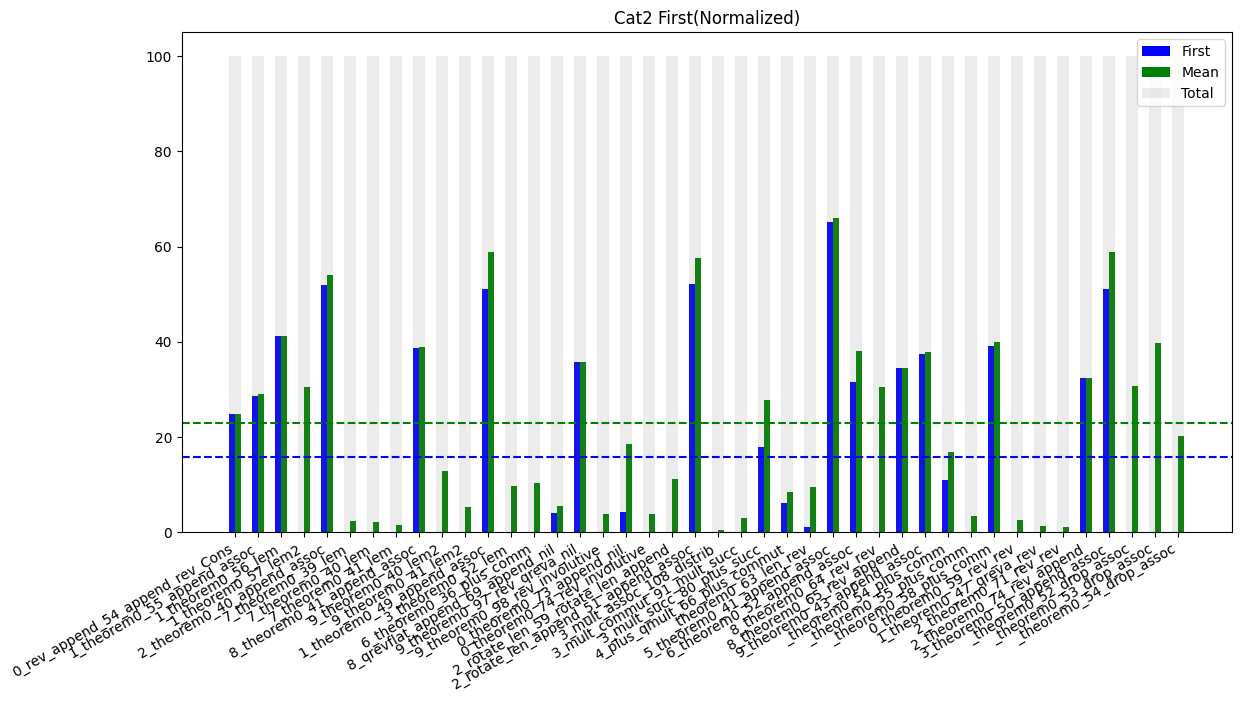

In [13]:
cat2_first_ranks, cat2_avg_ranks = order_by_lfind(frames)
visualize_ranks("Cat2 First", frames, cat2_first_ranks, cat2_avg_ranks)

In [15]:
sed_first_ranks = order_by_sed(frames)
ted_first_ranks = order_by_ted(frames)

In [22]:
def smallest_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def smallest_ugly_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('ugly_lemma_len', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

def smallest_sexp_first(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values('sexp_lemma_size', ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

In [54]:
f1, a1 = smallest_first(frames)
f2, a2 = smallest_ugly_first(frames)
f3, a3 = smallest_sexp_first(frames)

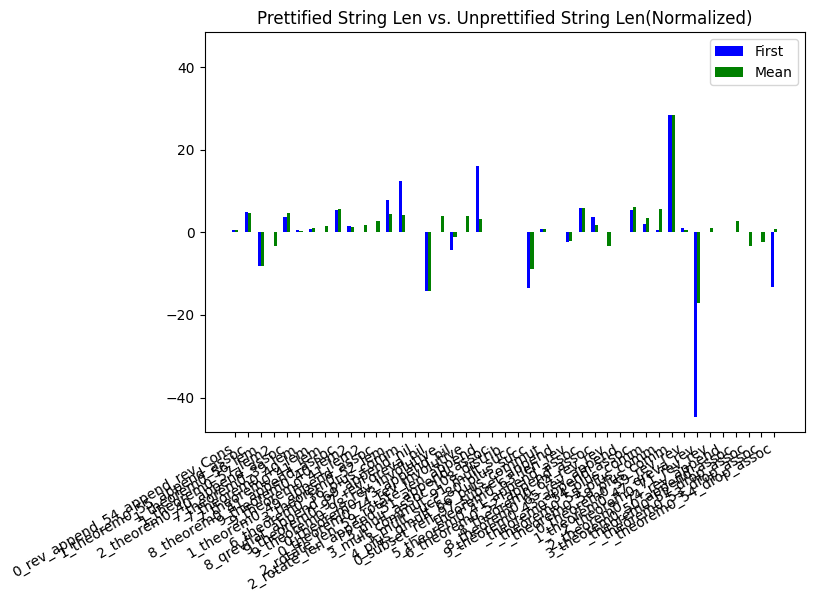

In [55]:
visualize_rank_difference("Prettified String Len vs. Unprettified String Len", frames, f1, a1, f2, a2)

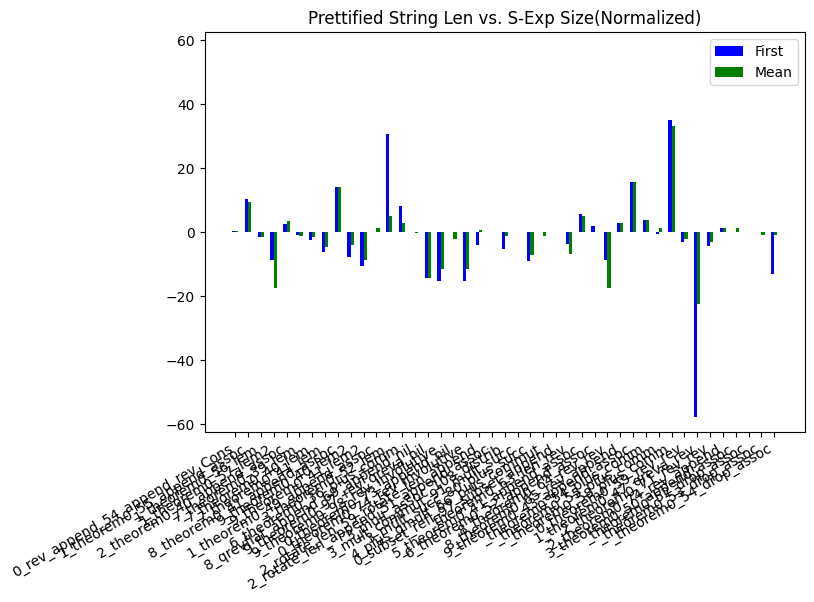

In [56]:
visualize_rank_difference("Prettified String Len vs. S-Exp Size", frames, f1, a1, f3, a3)


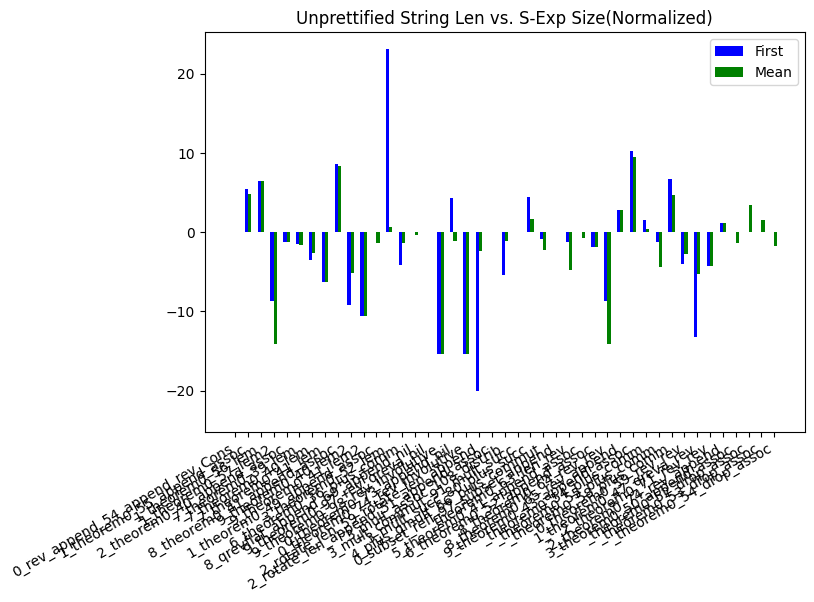

In [57]:
visualize_rank_difference("Unprettified String Len vs. S-Exp Size", frames, f2, a2, f3, a3)


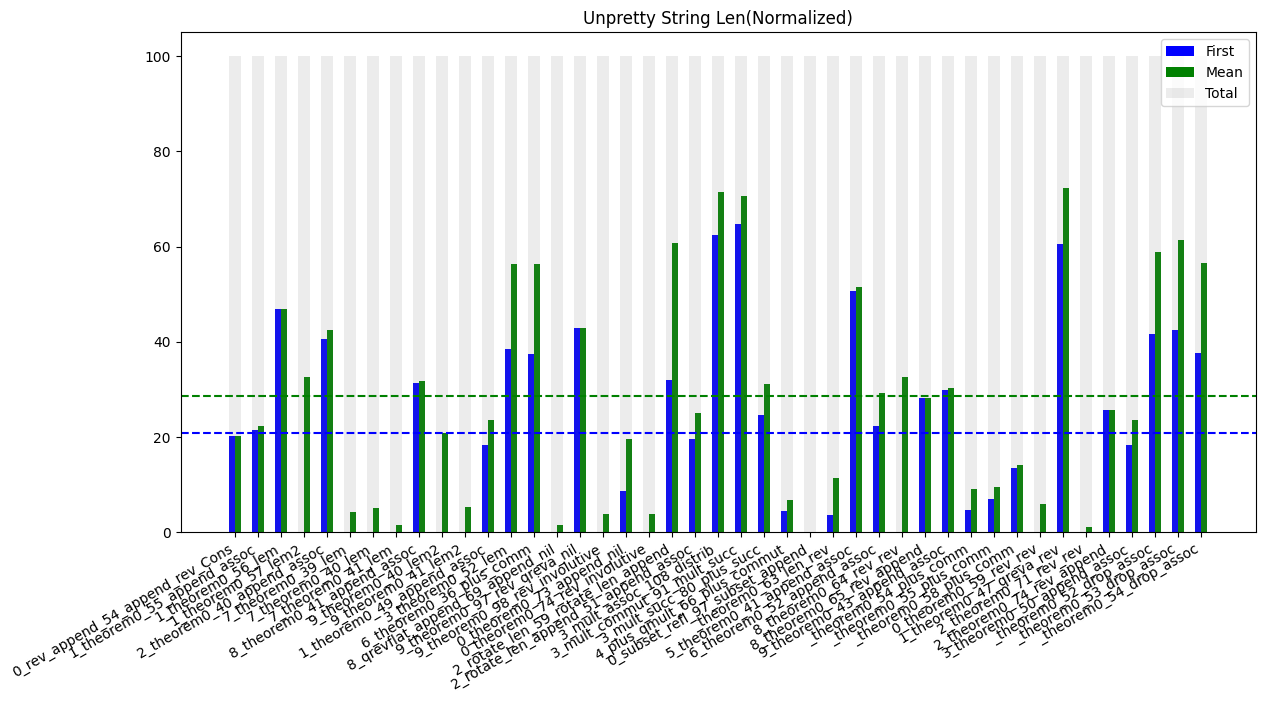

In [58]:
visualize_ranks("Unpretty String Len", frames, f2, a2)

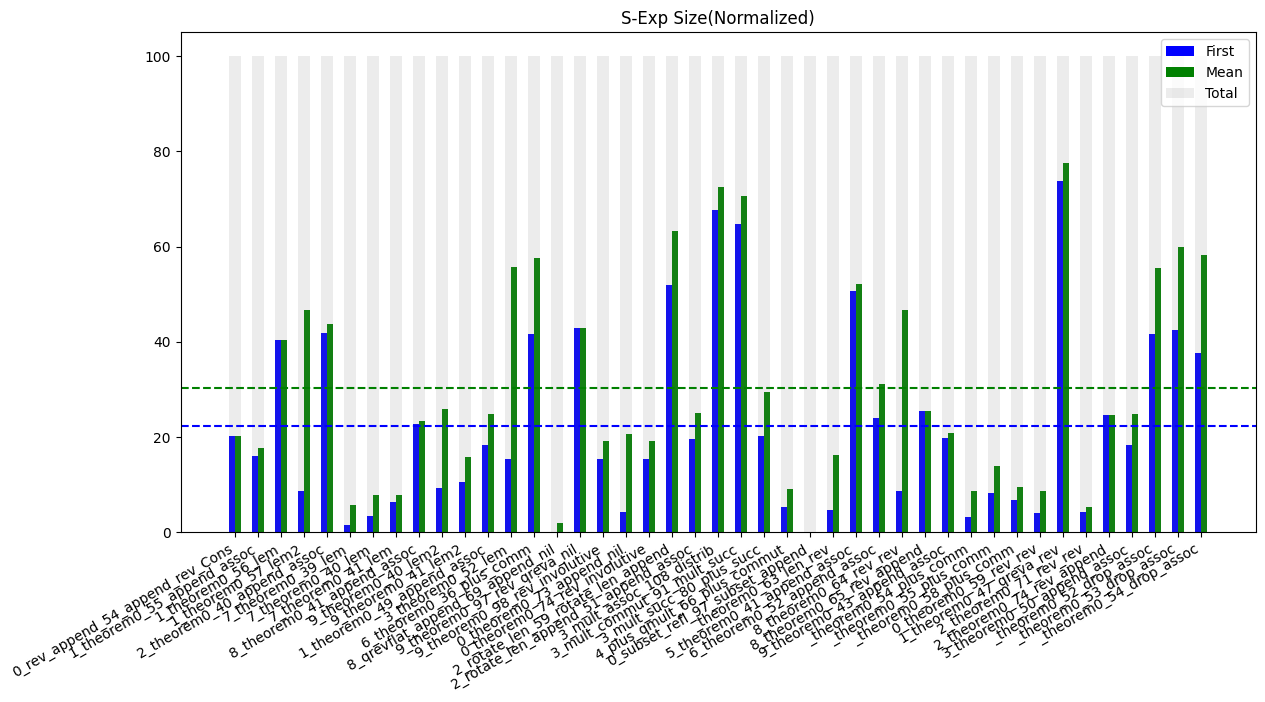

In [59]:
visualize_ranks("S-Exp Size", frames, f3, a3)

In [26]:
sed_f, sed_a = order_by_sed(frames)
ted_f, ted_a = order_by_ted(frames)

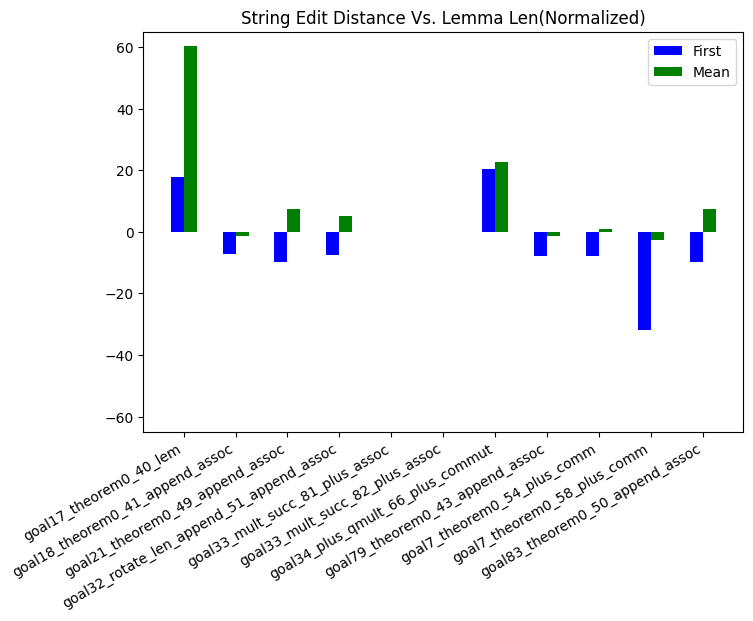

In [165]:
visualize_rank_difference("String Edit Distance Vs. Lemma Len", frames, sed_f, sed_a, a1, a2)

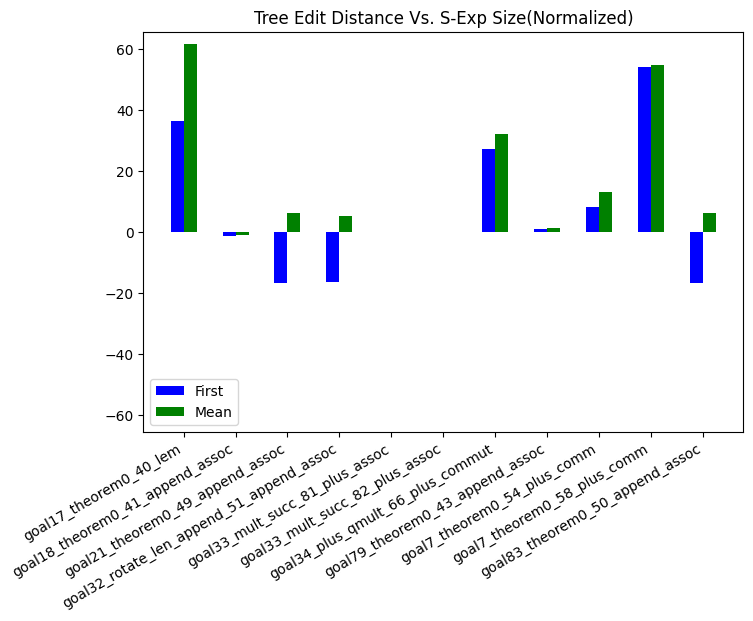

In [167]:
visualize_rank_difference("Tree Edit Distance Vs. S-Exp Size", frames, ted_f, ted_a, a3, a3)

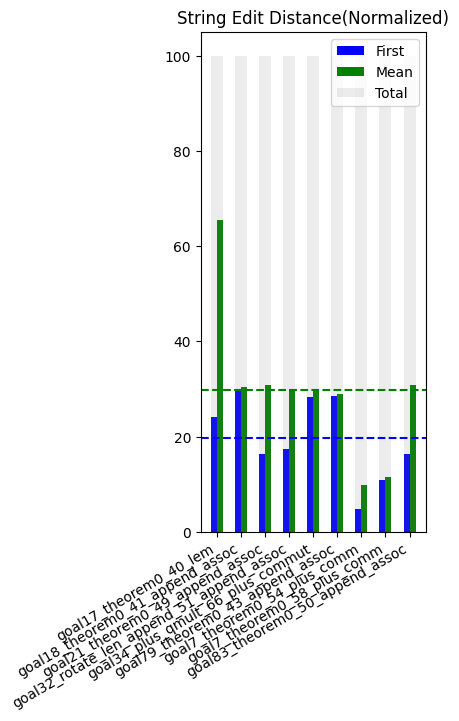

In [27]:
visualize_ranks("String Edit Distance", frames, sed_f, sed_a)

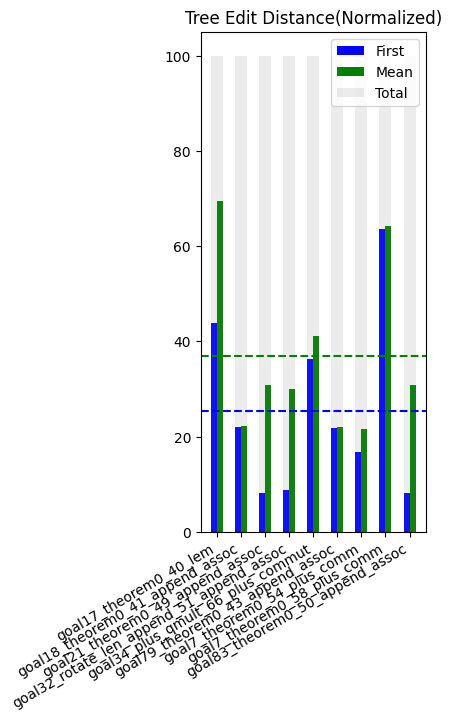

In [28]:
visualize_ranks("Tree Edit Distance", frames, ted_f, ted_a)


In [27]:
from collections import Counter
cnt = Counter()
for frame in frames:
  cnt[len(frame[frame['is_equiv'] == True])] += 1

cnt

Counter({1: 5, 3: 2, 4: 10, 2: 11, 6: 10, 5: 1, 8: 1, 7: 1, 21: 1})

In [22]:
from sklearn.linear_model import LogisticRegression
merged = pd.concat(frames)
merged.columns

Index(['cat', 'lemma', 'lemma_name', 'file', 'theorem_name',
       'helper_lemma_name', 'prelude', 'stuck_state', 'prefix',
       'helper_lemma_prefix', 'helper_lemma', 'helper_lemma_proof', 'theorem',
       'theorem_proof', 'alpha', 'ugly_lemma', 'ugly_theorem',
       'ugly_helper_lemma', 'lemma_len', 'ugly_lemma_len', 'sexp_lemma_size',
       'norm_lemma_len', 'norm_ugly_lemma_len', 'norm_sexp_lemma_size',
       'is_weaker', 'is_stronger', 'is_equiv', 'ted', 'sed', 'use_IH_before',
       'can_use_IH_before', 'can_use_IH_after', 'simpl_before',
       'can_use_synth', 'simpl_after'],
      dtype='object')

In [23]:
features = ['norm_lemma_len', 'norm_ugly_lemma_len',
       'norm_sexp_lemma_size', 'ted', 'sed', 'use_IH_before', 'can_use_IH_before', 'can_use_IH_after',
       'simpl_before', 'can_use_synth', 'simpl_after']
X, y = merged[features], merged[['is_equiv']]
Xtrain, ytrain = X[X['alpha'] <= 0.8], y[X['alpha'] <= 0.8]
Xtest, ytest = X[X['alpha'] > 0.8], y[X['alpha'] > 0.8]

KeyError: 'alpha'

In [24]:
clf = LogisticRegression().fit(X.values.tolist(), y.values.tolist())
print(clf.score(X.values.tolist(), y.values.tolist()))
print(clf.score(X[y['is_equiv'] == 0].values.tolist(), y[y['is_equiv'] == 0].values.tolist()))
print(clf.score(X[y['is_equiv'] == 1].values.tolist(), y[y['is_equiv'] == 1].values.tolist()))

/home/yousef/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9484597156398105
1.0
0.0


/home/yousef/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
results = clf.predict_proba(X.values.tolist())

In [26]:
tmp = merged
tmp["prob_not_equiv"], tmp["prob_equiv"] = [res[0] for res in results], [res[1] for res in results]

In [27]:
frames = []
for filename in tmp["file"].unique():
  frame = tmp[tmp["file"] == filename]
  if 1 in frame['cat'].unique():
    continue
  elif frame['is_equiv'].any():
    frames.append(frame)
  else:
    print(f"Excluding file: {filename} because none of the synthesized lemmas are equivalent to human lemma")
frames = sorted(frames, key=lambda frame: frame.file[0])
for frame in frames:
  print(frame.at[0, 'file'])

def order_by_prob_equiv(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values(['prob_not_equiv'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

prob_equiv_first, prob_equiv_avg = order_by_prob_equiv(frames)

clam_lf_goal10_rev_append_54_append_rev_Cons
clam_lf_goal11_theorem0_55_append_assoc
clam_lf_goal11_theorem0_56_lem
clam_lf_goal11_theorem0_57_lem2
clam_lf_goal12_theorem0_40_append_assoc
clam_lf_goal17_theorem0_39_lem
clam_lf_goal17_theorem0_40_lem
clam_lf_goal17_theorem0_41_lem
clam_lf_goal18_theorem0_41_append_assoc
clam_lf_goal19_theorem0_40_lem2
clam_lf_goal19_theorem0_41_lem2
clam_lf_goal21_theorem0_49_append_assoc
clam_lf_goal23_theorem0_52_lem
clam_lf_goal26_theorem0_36_plus_comm
clam_lf_goal28_qrevflat_append_69_append_nil
clam_lf_goal29_theorem0_97_rev_qreva_nil
clam_lf_goal29_theorem0_98_rev_involutive
clam_lf_goal30_theorem0_73_append_nil
clam_lf_goal30_theorem0_74_rev_involutive
clam_lf_goal32_rotate_len_59_rotate_len_append
clam_lf_goal32_rotate_len_append_51_append_assoc
clam_lf_goal33_mult_assoc_108_distrib
clam_lf_goal33_mult_commut_91_mult_succ
clam_lf_goal33_mult_succ_80_plus_succ
clam_lf_goal34_plus_qmult_66_plus_commut
clam_lf_goal6_theorem0_63_len_rev
clam_lf_goal

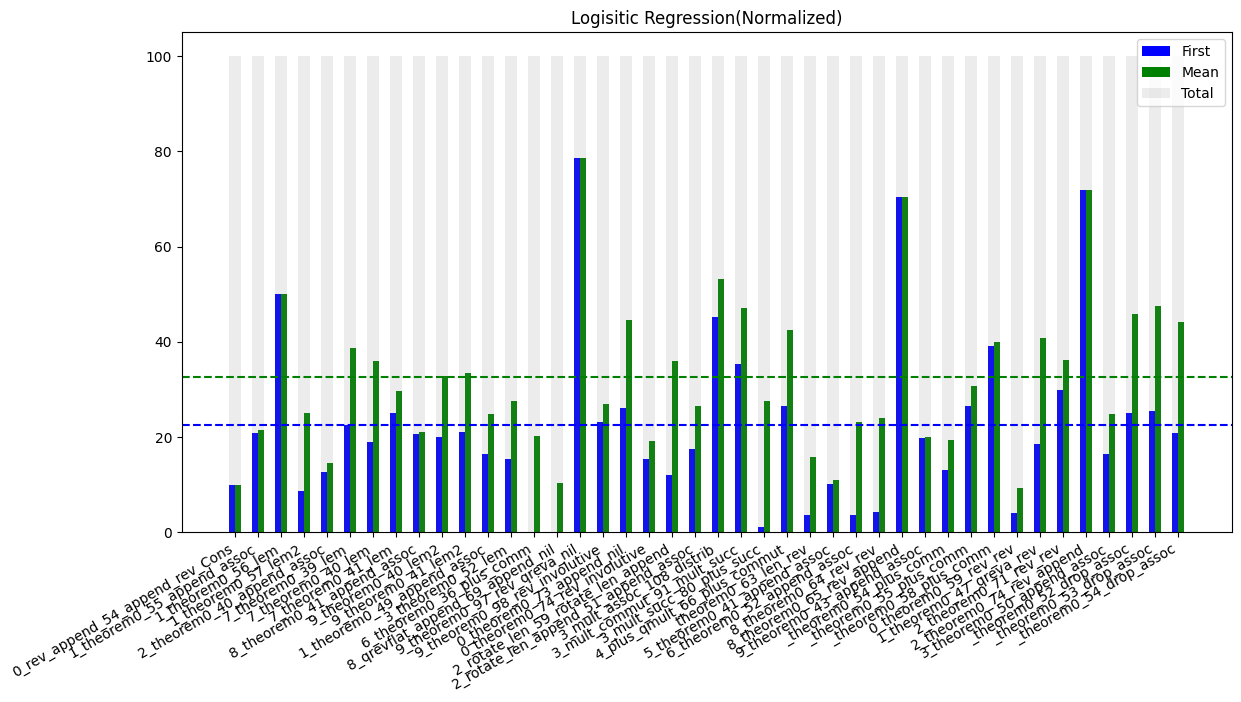

In [28]:
visualize_ranks("Logisitic Regression", frames, prob_equiv_first, prob_equiv_avg)

In [126]:
def solution_in_top_n(frames, sort_values, n=10):
  counts = []
  for index in range(len(frames)):
    sorted_frame = frames[index].sort_values(sort_values, ascending=True, ignore_index=True)
    counts.append(sorted_frame.head(n)['is_equiv'].any())
  return counts
  
print(Counter(solution_in_top_n(frames, ['alpha'])))
print(Counter(solution_in_top_n(frames, ['cat', 'lemma_len'])))
print(Counter(solution_in_top_n(frames, ['cat', 'lemma_len'])))
print(Counter(solution_in_top_n(frames, ['prob_not_equiv'])))

Counter({True: 23, False: 19})
Counter({True: 26, False: 16})
Counter({True: 25, False: 17})


In [141]:
def solution_in_top_n(frames, sort_values, n=10):
  counts = []
  for index in range(len(frames)):
    sorted_frame = frames[index].sort_values(sort_values, ascending=True, ignore_index=True)
    counts.append(sorted_frame.head(n)['is_equiv'].any())
  return counts
  
print(Counter(solution_in_top_n(frames, ['alpha'])))
print(Counter(solution_in_top_n(frames, ['cat', 'lemma_len'])))
print(Counter(solution_in_top_n(frames, ['prob_not_equiv'])))

Counter({True: 23, False: 19})
Counter({True: 26, False: 16})
Counter({True: 34, False: 8})


In [155]:
def solution_in_top_n(frames, sort_values, n=10):
  counts = []
  for index in range(len(frames)):
    sorted_frame = frames[index].sort_values(sort_values, ascending=True, ignore_index=True)
    counts.append(sorted_frame.head(n)['is_equiv'].any())
  return counts
  
print(Counter(solution_in_top_n(frames, ['alpha'])))
print(Counter(solution_in_top_n(frames, ['cat', 'lemma_len'])))
print(Counter(solution_in_top_n(frames, ['prob_not_equiv'])))

Counter({False: 5, True: 4})
Counter({False: 7, True: 2})
Counter({True: 8, False: 1})


In [20]:
def solution_in_top_n(frames, sort_values, n=10):
  counts = []
  for index in range(len(frames)):
    sorted_frame = frames[index].sort_values(sort_values, ascending=True, ignore_index=True)
    counts.append(sorted_frame.head(n)['is_equiv'].any())
  return counts
  
print(Counter(solution_in_top_n(frames, ['alpha'])))
print(Counter(solution_in_top_n(frames, ['cat', 'lemma_len'])))
print(Counter(solution_in_top_n(frames, ['prob_not_equiv'])))

Counter({True: 23, False: 19})
Counter({True: 26, False: 16})


KeyError: 'prob_not_equiv'

/home/yousef/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yousef/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


clam_lf_goal10_rev_append_54_append_rev_Cons
clam_lf_goal11_theorem0_55_append_assoc
clam_lf_goal11_theorem0_56_lem
clam_lf_goal11_theorem0_57_lem2
clam_lf_goal12_theorem0_40_append_assoc
clam_lf_goal17_theorem0_39_lem
clam_lf_goal17_theorem0_40_lem
clam_lf_goal17_theorem0_41_lem
clam_lf_goal18_theorem0_41_append_assoc
clam_lf_goal19_theorem0_40_lem2
clam_lf_goal19_theorem0_41_lem2
clam_lf_goal21_theorem0_49_append_assoc
clam_lf_goal23_theorem0_52_lem
clam_lf_goal26_theorem0_36_plus_comm
clam_lf_goal28_qrevflat_append_69_append_nil
clam_lf_goal29_theorem0_97_rev_qreva_nil
clam_lf_goal29_theorem0_98_rev_involutive
clam_lf_goal30_theorem0_73_append_nil
clam_lf_goal30_theorem0_74_rev_involutive
clam_lf_goal32_rotate_len_59_rotate_len_append
clam_lf_goal32_rotate_len_append_51_append_assoc
clam_lf_goal33_mult_assoc_108_distrib
clam_lf_goal33_mult_commut_91_mult_succ
clam_lf_goal33_mult_succ_80_plus_succ
clam_lf_goal34_plus_qmult_66_plus_commut
clam_lf_goal6_theorem0_63_len_rev
clam_lf_goal

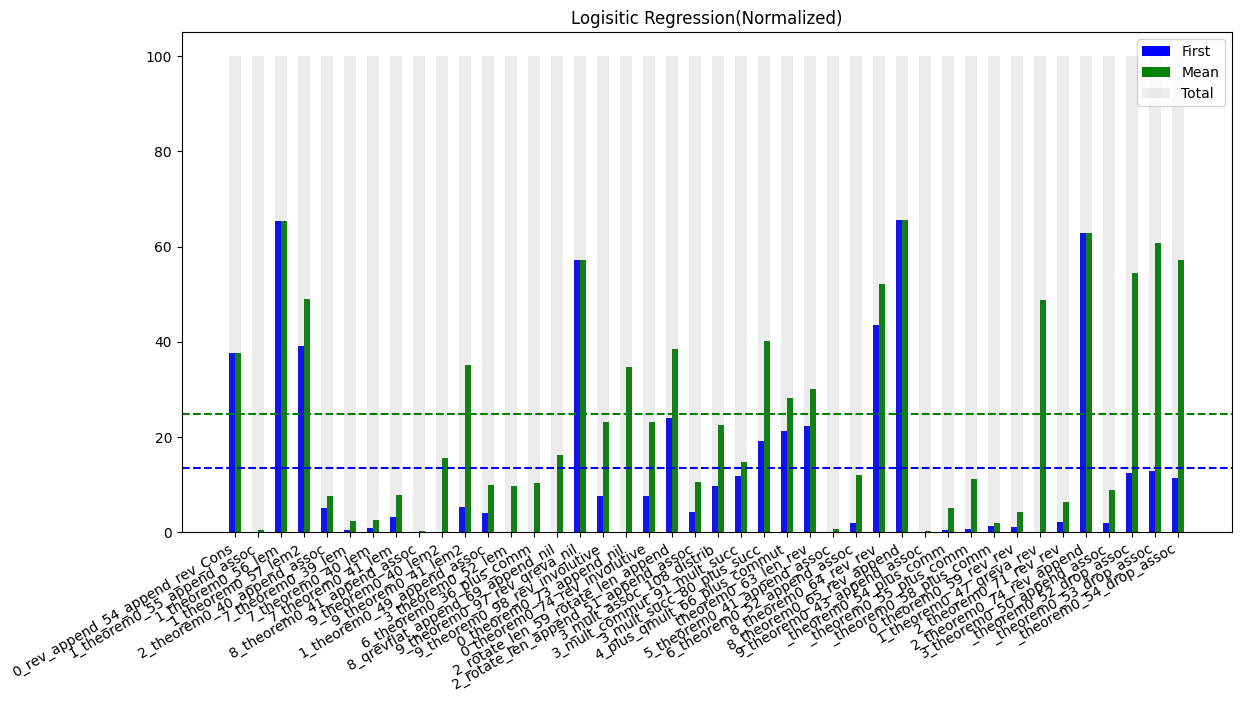

In [140]:
smallclam = pd.read_pickle('./smallclam.pickle')
features = ['cat', 'alpha', 'lemma_len', 'ugly_lemma_len',
       'sexp_lemma_size', 'norm_lemma_len', 'norm_ugly_lemma_len',
       'norm_sexp_lemma_size', 'ted', 'sed', 'use_IH_before', 'can_use_IH_before', 'can_use_IH_after',
       'simpl_before', 'can_use_synth', 'simpl_after']
smallclamX, smallclamY = smallclam[features], smallclam[['is_equiv']]
clf = LogisticRegression().fit(smallclamX.values.tolist(), smallclamY.values.tolist())
results = clf.predict_proba(X.values.tolist())

tmp = merged
tmp["prob_not_equiv"], tmp["prob_equiv"] = [res[0] for res in results], [res[1] for res in results]

frames = []
for filename in tmp["file"].unique():
  frame = tmp[tmp["file"] == filename]
  if 1 in frame['cat'].unique():
    continue
  elif frame['is_equiv'].any():
    frames.append(frame)
  else:
    print(f"Excluding file: {filename} because none of the synthesized lemmas are equivalent to human lemma")
frames = sorted(frames, key=lambda frame: frame.file[0])
for frame in frames:
  print(frame.at[0, 'file'])

def order_by_prob_equiv(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values(['prob_not_equiv'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

prob_equiv_first, prob_equiv_avg = order_by_prob_equiv(frames)
visualize_ranks("Logisitic Regression", frames, prob_equiv_first, prob_equiv_avg)

In [113]:
def many_solution_in_top_n(frames, sort_values, n=10):
  counts = {}
  for values in sort_values:
    counts[str(values)] = []
    for index in range(len(frames)):
      sorted_frame = frames[index].sort_values(values, ascending=True, ignore_index=True)
      counts[str(values)].append(sorted_frame.head(n)['is_equiv'].any())
  return counts
  
feature_lists = [
  ['lemma_len'],
  ['simpl_after'],
  ['can_use_IH_after'],
  ['prob_not_equiv'],
  ['dtree_not_equiv']
]
counts = many_solution_in_top_n(frames, feature_lists)
for k in counts: 
  print(k, Counter(counts[k]))
print("['or']", Counter(np.array(list(counts.values())).any(axis=0)))

['lemma_len'] Counter({False: 22, True: 20})
['simpl_after'] Counter({False: 27, True: 15})
['can_use_IH_after'] Counter({False: 25, True: 17})
['prob_not_equiv'] Counter({True: 26, False: 16})
['dtree_not_equiv'] Counter({True: 22, False: 20})
['or'] Counter({True: 36, False: 6})


In [29]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X.values.tolist(), y.values.tolist())
print(clf.score(X.values.tolist(), y.values.tolist()))
print(clf.score(X[y['is_equiv'] == 0].values.tolist(), y[y['is_equiv'] == 0].values.tolist()))
print(clf.score(X[y['is_equiv'] == 1].values.tolist(), y[y['is_equiv'] == 1].values.tolist()))

0.9496445497630331
1.0
0.022988505747126436


In [115]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['not_equiv', 'is_equiv']) 
graph = graphviz.Source(dot_data) 
graph.render("clam") 

'clam.pdf'

clam_lf_goal10_rev_append_54_append_rev_Cons
clam_lf_goal11_theorem0_55_append_assoc
clam_lf_goal11_theorem0_56_lem
clam_lf_goal11_theorem0_57_lem2
clam_lf_goal12_theorem0_40_append_assoc
clam_lf_goal17_theorem0_39_lem
clam_lf_goal17_theorem0_40_lem
clam_lf_goal17_theorem0_41_lem
clam_lf_goal18_theorem0_41_append_assoc
clam_lf_goal19_theorem0_40_lem2
clam_lf_goal19_theorem0_41_lem2
clam_lf_goal21_theorem0_49_append_assoc
clam_lf_goal23_theorem0_52_lem
clam_lf_goal26_theorem0_36_plus_comm
clam_lf_goal28_qrevflat_append_69_append_nil
clam_lf_goal29_theorem0_97_rev_qreva_nil
clam_lf_goal29_theorem0_98_rev_involutive
clam_lf_goal30_theorem0_73_append_nil
clam_lf_goal30_theorem0_74_rev_involutive
clam_lf_goal32_rotate_len_59_rotate_len_append
clam_lf_goal32_rotate_len_append_51_append_assoc
clam_lf_goal33_mult_assoc_108_distrib
clam_lf_goal33_mult_commut_91_mult_succ
clam_lf_goal33_mult_succ_80_plus_succ
clam_lf_goal34_plus_qmult_66_plus_commut
clam_lf_goal6_theorem0_63_len_rev
clam_lf_goal

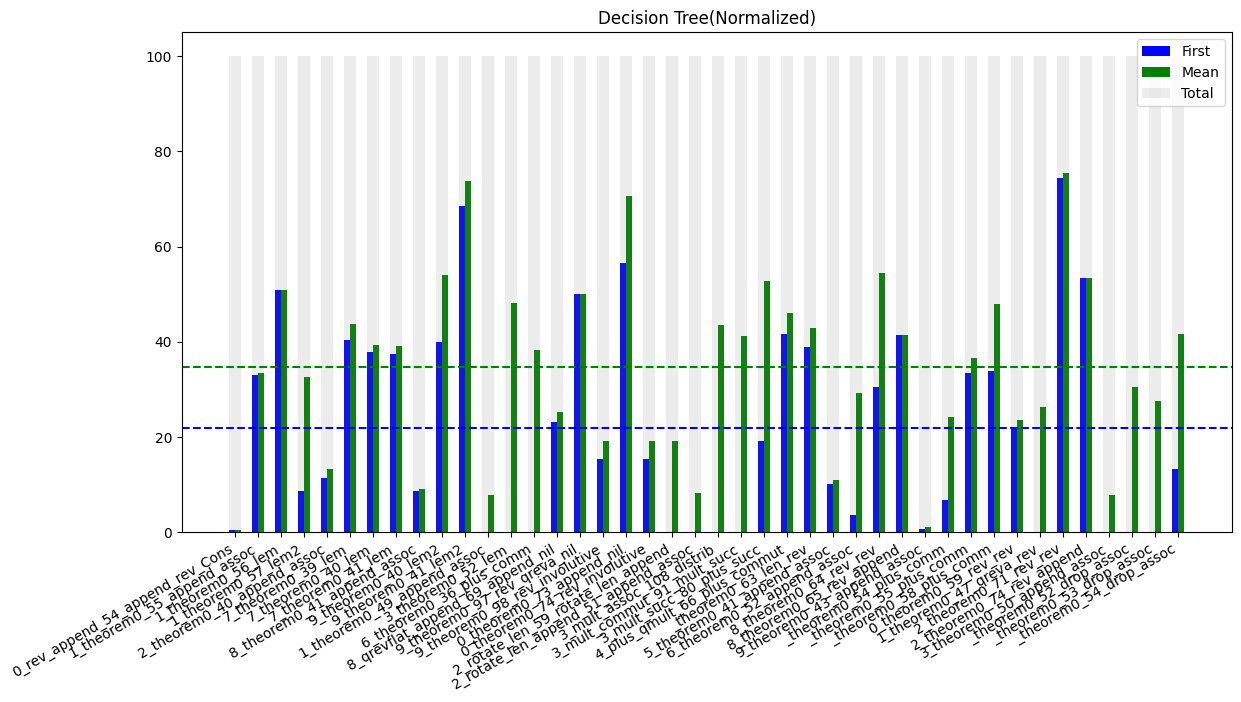

In [32]:
results = clf.predict_proba(X.values.tolist())

tmp = merged
tmp["dtree_not_equiv"], tmp["dtree_prob_equiv"] = [res[0] for res in results], [res[1] for res in results]

frames = []
for filename in tmp["file"].unique():
  frame = tmp[tmp["file"] == filename]
  if 1 in frame['cat'].unique():
    continue
  elif frame['is_equiv'].any():
    frames.append(frame)
  else:
    print(f"Excluding file: {filename} because none of the synthesized lemmas are equivalent to human lemma")
frames = sorted(frames, key=lambda frame: frame.file[0])
for frame in frames:
  print(frame.at[0, 'file'])

def order_by_dtree_equiv(frames):
  first_rank = [[] for i in range(len(frames))]
  mean_rank = [[] for i in range(len(frames))]
  for index in range(len(frames)):
    all_equiv = []
    sorted_frame = frames[index].sort_values(['dtree_not_equiv'], ascending=True, ignore_index=True)
    for i, row in sorted_frame.iterrows():
      if row["is_equiv"]:
        all_equiv.append(i)
    if not all_equiv:
      all_equiv.append(NaN)
    first_rank[index].append(all_equiv[0])
    mean_rank[index].append(mean(all_equiv))
  return [mean(first_rank[i]) for i in range(len(frames))], [mean(mean_rank[i]) for i in range(len(frames))]

dtree_equiv_first, dtree_equiv_avg = order_by_dtree_equiv(frames)
visualize_ranks("Decision Tree", frames, dtree_equiv_first, dtree_equiv_avg)

In [54]:
interesting_features = ['alpha', 'norm_lemma_len', 'norm_ugly_lemma_len',
      'norm_sexp_lemma_size', 'ted', 'sed', 'use_IH_before', 'can_use_IH_before', 'can_use_IH_after',
      'simpl_before', 'can_use_synth', 'simpl_after', 'prob_not_equiv', 'dtree_not_equiv']

def compare_features(frames, normalize=True):
  first_ranks, avg_ranks, solved = [], [], []
  for feature in interesting_features:
    franks, aranks = order_by(frames, feature, normalize)
    
    first_ranks.append(mean(franks))
    avg_ranks.append(mean(aranks))
    solved.append(solution_in_top_n(frames, feature))
  return first_ranks, avg_ranks, solved

/home/yousef/.local/lib/python3.8/site-packages/numpy/lib/stride_tricks.py:537: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/home/yousef/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: setting an array element with a sequence.

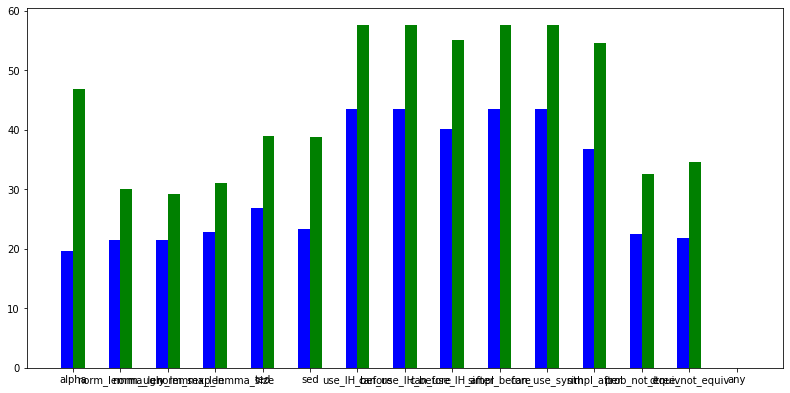

In [72]:
def visualize_features(frames, normalize=True):
  first_ranks, avg_ranks, solved = compare_features(frames, normalize)
  first_ranks.append(0)
  avg_ranks.append(0)
  solved.append(0)
  X = np.arange(len(interesting_features) + 1)
  fig = plt.figure(figsize=(len(frames)/4,5))
  ax = fig.add_axes([0,0,1,1])
  ax.set_xticks(80 * np.arange(len(interesting_features) + 1), [str(feature) for feature in interesting_features] + ['any'])
  ax.bar(80 * X + -10, first_ranks, color = 'b', width = 20)
  ax.bar(80 * X + 10, avg_ranks, color = 'g', width = 20)
  ax.bar(80 * X + 30, solved, color = 'r', width = 20)
  ax.bar(80 * X + 30, len(frames), color = 'r', width = 20, alpha=0.2)
  fig.autofmt_xdate()
  fig.set_dpi(100)

visualize_features(frames)
  
  

In [69]:
frame = frame.sort_values("can_simpl_synth")

In [68]:
generate_dataframes.add_column(frame, generate_dataframes.can_simpl_synth)

In [75]:
tmp = merged[merged["can_use_IH_after"] == True]